# XGBoost - Caso Titanic

En este notebook, utilizaremos XGBoost para entrenar un algoritmo de clasificación que permita establecer un modelo que prediga los sobrevivientes del dataset Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carga de Datos y Análisis Exploratorio

In [4]:
df = pd.read_csv('titanic.csv')

In [6]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Valores perdidos

La cabina no aporta mucho en el análisis, pero la edad es una variable importante para predecir si una persona sobrevivió o no a la trajedia. A continuación, una forma de "visualizar" los valores perdidos.

Haremos una imputación de la edad del pasajero en función del promedio de edad de la clase en la que viajaba.

In [11]:
edades = df.groupby('Pclass')['Age'].mean().round()
edades

Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

In [13]:
# creamos una funcion que imputa la edad en caso de estar nula
def imputar_edad(cols):
    edad = edad = cols.iloc[0]
    pclass = pclass = cols.iloc[1]
    if(pd.isnull(edad)):
        if(pclass==1):
            return 38
        if(pclass==2):
            return 30
        if(pclass==3):
            return 25
    else:
        return edad

In [15]:
df['Age'] = df[['Age','Pclass']].apply(imputar_edad, axis=1)

In [17]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Formulación del modelo

En esta sección seleccionaremos las variables que incorporaremos en la matriz de predictores "X" y en el vector de resultados "y", ya que no todas las columnas son de utilidad.

In [20]:
X = df[['Age','Sex','Fare']]
y = df['Survived']

In [22]:
X = pd.get_dummies(X, drop_first=True)

In [24]:
X.head(2)

,Age,Fare,Sex_male
0,22.0,7.2500,True
1,38.0,71.2833,False


### Validación Cruzada

In [27]:
from sklearn.model_selection import train_test_split

Nótese que si utilizamos random_state 0 y 41, obtenemos un performance distinto para cada caso

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)  # 41, 0

### Modelamiento con XGBoost

In [33]:
from xgboost import XGBClassifier

In [35]:
clf = XGBClassifier(random_state = 0)

In [37]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [39]:
# score en set de entrenamiento
clf.score(X_train,y_train)

0.9550561797752809

In [41]:
# score en set de test
clf.score(X_test,y_test)

0.8268156424581006

## Hiperparámetros

In [44]:
xgb = XGBClassifier(n_estimators=100, 
                    max_depth=10, 
                    learning_rate=0.01, 
                    colsample_bytree=0.8,
                   random_state = 0)

In [46]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [48]:
# score en set de entrenamiento
xgb.score(X_train,y_train)

0.8637640449438202

In [50]:
# score en set de test
xgb.score(X_test,y_test)

0.8268156424581006

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [54]:
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10, 20],
    'colsample_bytree': [0.5, 0.8],
}

In [62]:
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')

In [64]:
xgb_grid_search = GridSearchCV(xgb_model, param_grid=xgb_params, cv=5, scoring='accuracy')

In [66]:
print("Searching for best hyperparameters for XGBoost...")
xgb_grid_search.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_grid_search.best_params_}, Best Score: {xgb_grid_search.best_score_}")

Searching for best hyperparameters for XGBoost...
Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}, Best Score: 0.799133261105092


In [76]:
xgb_grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [78]:
xgb_best_model = xgb_grid_search.best_estimator_

In [80]:
xgb_best_model.score(X_train,y_train)

0.898876404494382

In [82]:
xgb_best_model.score(X_test,y_test)

0.8324022346368715

In [84]:
xgb_params_extended = {
    'n_estimators': [100],
    'learning_rate': [0.5],
    'max_depth': [10],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1]
}

In [86]:
extended_xgb_grid_search = GridSearchCV(
    xgb_model, param_grid=xgb_params_extended, cv=5, scoring='accuracy'
)


In [88]:
extended_xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.5], 'max_depth': [10],
                         'n_estimators': [100], 'reg_alpha': [0, 0.01, 0.1],
                         'subsample': [0.8, 1]},
             scoring='accuracy')

In [90]:
extended_xgb_grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.5,
 'max_depth': 10,
 'n_estimators': 100,
 'reg_alpha': 0.1,
 'subsample': 1}

In [92]:
xgb_best_model_ex = xgb_grid_search.best_estimator_

In [94]:
xgb_best_model_ex.score(X_train,y_train)

0.898876404494382

In [96]:
xgb_best_model_ex.score(X_test,y_test)

0.8324022346368715

In [98]:
importance_xgb = xgb_best_model_ex.feature_importances_

In [100]:
def plot_feature_importance(importances, feature_names, model_name):
    indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
    plt.figure(figsize=(10, 6))
    plt.title(f"{model_name} Feature Importances")
    plt.bar(range(len(importances)), importances[indices], color="r", align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

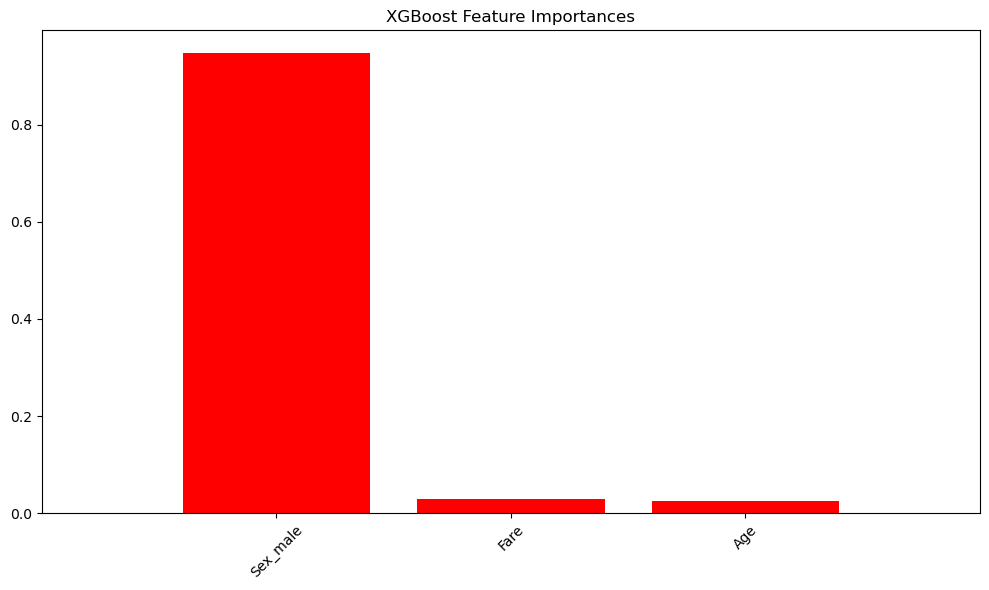

In [102]:
plot_feature_importance(importance_xgb, X_train.columns, "XGBoost")

In [104]:
y_pred = xgb_best_model_ex.predict(X_test)

In [106]:
y_pred

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0])